In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import sys
sys.path.append("../IIC")

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.cm as cm

keras = tf.keras
K = tf.keras.backend

In [5]:
tf.__version__

'2.0.0'

In [6]:
import superglue.iic_datasets_ops as iic_datasets_ops
import superglue.iic_mnist_dataset_ops as mnist_ops
import utils
import models

In [7]:
batch_size = 64
num_classes = 10
# latent_size = 64
input_shape = (28, 28, 1)
num_train_steps = 60000 // batch_size
num_eval_steps = 10000 // batch_size

In [8]:
train_dataset, dataset_info = tfds.load(name="mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="mnist", split=tfds.Split.TEST, as_supervised=True)

In [9]:
train_dataset

<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

In [10]:
first_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(
    rotation=0.1, skew=0.05, translation=0.05, crop=0.1, uniform_noise=0)
second_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(crop=0.1, translation=0.05)

# first_image_aug_fn = mnist_ops.mnist_x_aug_fn
# second_image_aug_fn = mnist_ops.mnist_gx_aug_fn

iic_train_dataset, model_input_shape = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset,
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    input_size=input_shape[:2],
)

# cls_train_dataset, _ = iic_datasets_ops.prepare_dataset(
#     dataset=train_dataset.take(200),
#     first_image_aug_fn=first_image_aug_fn,
#     second_image_aug_fn=second_image_aug_fn,
#     batch_size=batch_size,
#     num_image_repeats=num_repeats,
#     input_size=input_shape[:2],
# )

iic_test_dataset, _ = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset,
    first_image_aug_fn=mnist_ops.get_mnist_test_x_aug_fn(input_shape),
    second_image_aug_fn=mnist_ops.get_mnist_test_x_aug_fn(input_shape),
    batch_size=batch_size,
    input_size=input_shape[:2],
)

In [11]:
iic_train_dataset, iic_test_dataset

(<PrefetchDataset shapes: ({image: (None, 28, 28, 1), tf_image: (None, 28, 28, 1)}, {label: (None,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>,
 <PrefetchDataset shapes: ({image: (None, 28, 28, 1), tf_image: (None, 28, 28, 1)}, {label: (None,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>)

In [12]:
model_input_shape

[28, 28, 1]

In [13]:
iic_train_iterator = iter(iic_train_dataset)
iic_test_iterator = iter(iic_test_dataset)

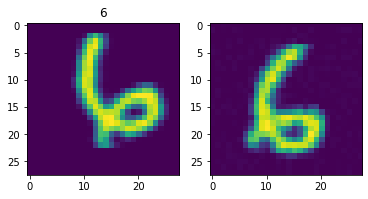

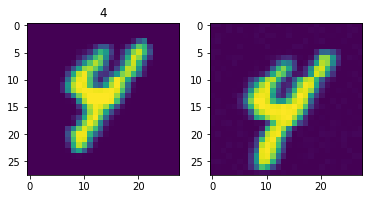

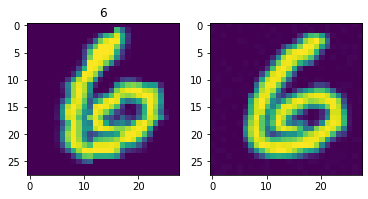

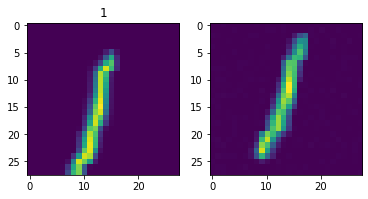

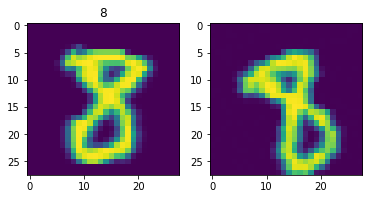

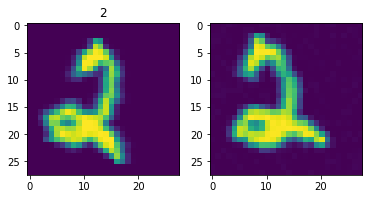

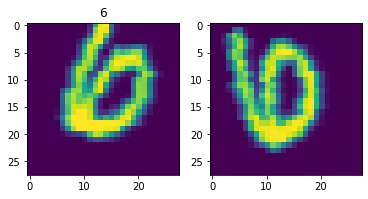

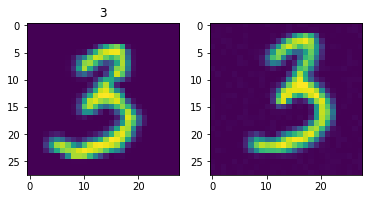

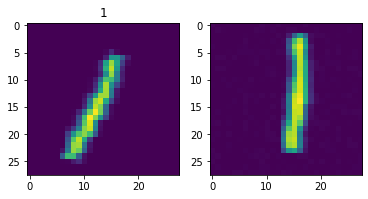

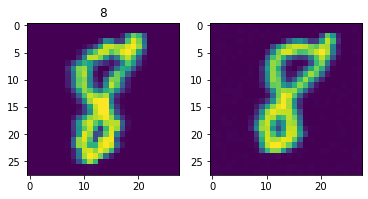

In [14]:
utils.plot_image_pairs(*next(iic_train_iterator), num_examples=10)

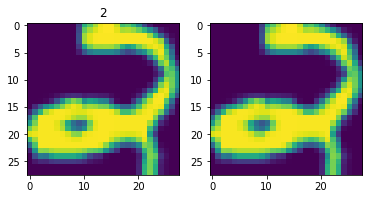

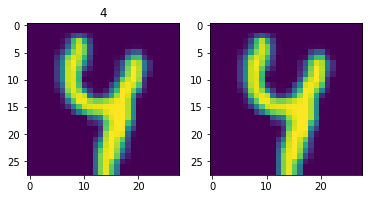

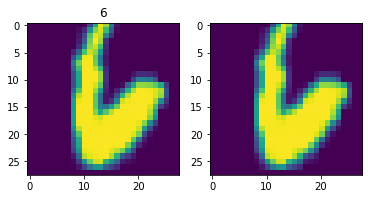

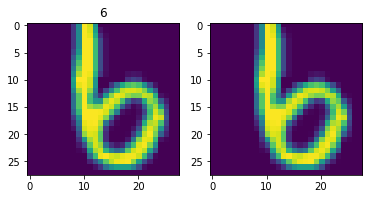

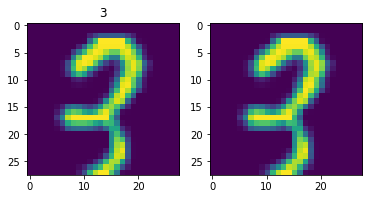

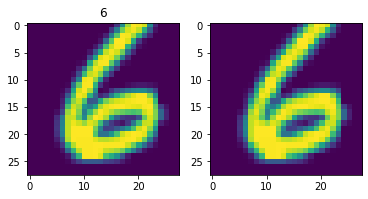

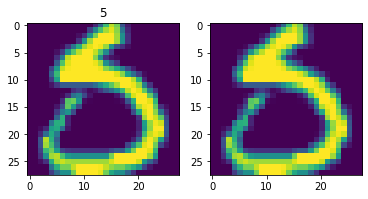

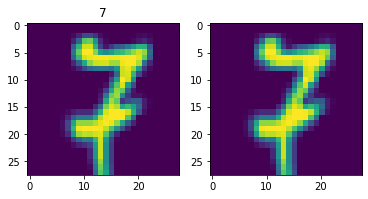

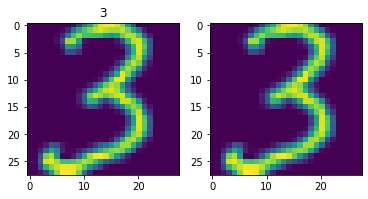

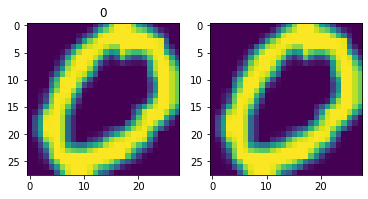

In [15]:
utils.plot_image_pairs(*next(iic_test_iterator), num_examples=10)

In [16]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 41.59 times longer than the fastest. This could mean that an intermediate result is being cached.
8.27 ms ± 5.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
from superglue.losses import SinkhornKnoppLayer, get_assignment_loss

In [18]:
base_model = models.create_resnet_se_backbone(model_input_shape, (1, 1), attention=None)
optimal_assignment = SinkhornKnoppLayer(lam=10.0, num_steps=100)

In [19]:
prediction_model = keras.Sequential([    
    base_model,
    keras.layers.Flatten(),
    keras.layers.Dense(num_classes, activation=None),
    keras.layers.Lambda(lambda x: tf.reshape(x, [1, batch_size, num_classes]))
])

In [20]:
prediction_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4, 4, 128)         312387    
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
_________________________________________________________________
lambda (Lambda)              (1, 64, 10)               0         
Total params: 332,877
Trainable params: 331,851
Non-trainable params: 1,026
_________________________________________________________________


In [21]:
image_input = keras.Input(shape=model_input_shape, name="image")
tf_image_input = keras.Input(shape=model_input_shape, name="tf_image")

image_predictions = prediction_model(image_input)
tf_image_predictions = prediction_model(tf_image_input)

In [22]:
image_predictions

<tf.Tensor 'sequential/Identity:0' shape=(1, 64, 10) dtype=float32>

In [23]:
Pij, Sij = optimal_assignment(image_predictions, tf_image_predictions)

In [24]:
Pij

<tf.Tensor 'sinkhorn_knopp_layer/Identity:0' shape=(1, 64, 64) dtype=float32>

In [25]:
inputs = {
    "image": image_input,
    "tf_image": tf_image_input
}
sinkhorn_knopp_model = keras.Model(inputs=inputs, outputs=[Pij])

In [26]:
loss_fn = get_assignment_loss(1 / batch_size)

In [27]:
def softmax_self_entropy_loss(logits):
    probs = tf.nn.softmax(tf.squeeze(logits))
    entropy = - probs * tf.math.log(tf.clip_by_value(probs, 1e-7, 1.0))
    loss = tf.reduce_sum(entropy, axis=-1) 
    return tf.reduce_mean(loss)
    
scale = 0.05
probs_entropy = softmax_self_entropy_loss(image_predictions)
tf_probs_entropy = softmax_self_entropy_loss(tf_image_predictions)
probs_entropy

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [28]:
sinkhorn_knopp_model.add_loss(scale * probs_entropy)
sinkhorn_knopp_model.add_loss(scale * tf_probs_entropy)

In [29]:
sinkhorn_knopp_model.add_metric(probs_entropy, aggregation='mean', name='probs_entropy')
sinkhorn_knopp_model.add_metric(tf_probs_entropy, aggregation='mean', name='tf_probs_entropy')

In [30]:
import numpy as np

In [31]:
def map_dataset_for_sinkhorn_knopp_labels(features, labels):
    target_probs = tf.convert_to_tensor(np.eye(batch_size, dtype=np.float32))
    target_probs = tf.expand_dims(target_probs, 0)
    return features, target_probs

unsupervised_train_dataset = iic_train_dataset.map(map_dataset_for_sinkhorn_knopp_labels)
unsupervised_train_dataset

<MapDataset shapes: ({image: (None, 28, 28, 1), tf_image: (None, 28, 28, 1)}, (1, 64, 64)), types: ({image: tf.float32, tf_image: tf.float32}, tf.float32)>

In [32]:
sinkhorn_knopp_model.predict(unsupervised_train_dataset, steps=1).shape

(1, 64, 64)

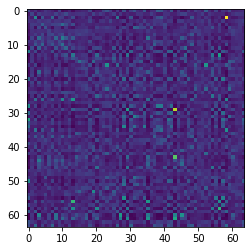

In [33]:
predicted_batch_pij_np = sinkhorn_knopp_model.predict(unsupervised_train_dataset, steps=1)[0]
plt.imshow(predicted_batch_pij_np)

In [34]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
sinkhorn_knopp_model.compile(optimizer=optimizer, loss=loss_fn)

In [35]:
sinkhorn_knopp_model.fit(
    unsupervised_train_dataset, verbose=1, epochs=10,
    steps_per_epoch=100, 
)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 20s 200ms/step - loss: 1.2648 - probs_entropy: 0.8822 - tf_probs_entropy: 0.9066
Epoch 2/10
100/100 [==============================] - 14s 136ms/step - loss: 0.6538 - probs_entropy: 0.6401 - tf_probs_entropy: 0.6611
Epoch 3/10
100/100 [==============================] - 14s 137ms/step - loss: 0.5192 - probs_entropy: 0.5440 - tf_probs_entropy: 0.5625
Epoch 4/10
100/100 [==============================] - 14s 142ms/step - loss: 0.4637 - probs_entropy: 0.4781 - tf_probs_entropy: 0.4989
Epoch 5/10
100/100 [==============================] - 14s 138ms/step - loss: 0.4165 - probs_entropy: 0.4306 - tf_probs_entropy: 0.4443
Epoch 6/10
100/100 [==============================] - 15s 146ms/step - loss: 0.3809 - probs_entropy: 0.3797 - tf_probs_entropy: 0.3969
Epoch 7/10
100/100 [==============================] - 15s 151ms/step - loss: 0.3559 - probs_entropy: 0.3464 - tf_probs_entropy: 0.3602
Epoch 8/10
100/100 [===============

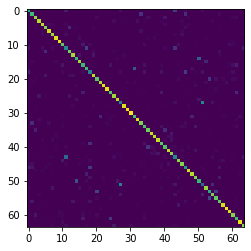

In [36]:
predicted_batch_pij_np = sinkhorn_knopp_model.predict(unsupervised_train_dataset, steps=1)[0]
plt.imshow(predicted_batch_pij_np)

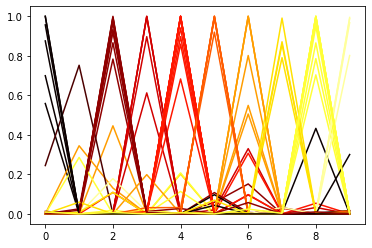

In [37]:
batch = next(iic_train_iterator)
logits_np = prediction_model.predict(x=batch[0]['image'], steps=1)[0]
for probs in tf.nn.softmax(logits_np).numpy():
    c = cm.hot(probs.argmax()/num_classes)
    plt.plot(probs, c=c)

In [38]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
sinkhorn_knopp_model.compile(optimizer=optimizer, loss=loss_fn)
sinkhorn_knopp_model.fit(
    unsupervised_train_dataset, verbose=1, epochs=10, steps_per_epoch=200,
)

Train for 200 steps
Epoch 1/10
200/200 [==============================] - 36s 180ms/step - loss: 0.3019 - probs_entropy: 0.2610 - tf_probs_entropy: 0.2687
Epoch 2/10
200/200 [==============================] - 30s 149ms/step - loss: 0.2851 - probs_entropy: 0.2341 - tf_probs_entropy: 0.2406
Epoch 3/10
200/200 [==============================] - 30s 152ms/step - loss: 0.2775 - probs_entropy: 0.2273 - tf_probs_entropy: 0.2310
Epoch 4/10
200/200 [==============================] - 33s 163ms/step - loss: 0.2662 - probs_entropy: 0.2113 - tf_probs_entropy: 0.2151
Epoch 5/10
200/200 [==============================] - 32s 159ms/step - loss: 0.2646 - probs_entropy: 0.1982 - tf_probs_entropy: 0.2011
Epoch 6/10
200/200 [==============================] - 32s 158ms/step - loss: 0.2588 - probs_entropy: 0.1856 - tf_probs_entropy: 0.1940
Epoch 7/10
200/200 [==============================] - 33s 166ms/step - loss: 0.2515 - probs_entropy: 0.1830 - tf_probs_entropy: 0.1838
Epoch 8/10
200/200 [===============

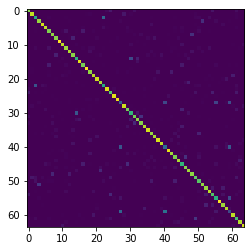

In [39]:
predicted_batch_pij_np = sinkhorn_knopp_model.predict(unsupervised_train_dataset, steps=1)[0]
plt.imshow(predicted_batch_pij_np)

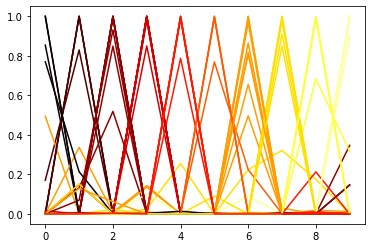

In [41]:
batch = next(iic_train_iterator)
logits_np = prediction_model.predict(x=batch[0]['image'], steps=1)[0]
for probs in tf.nn.softmax(logits_np).numpy():
    c = cm.hot(probs.argmax()/num_classes)
    plt.plot(probs, c=c)

In [51]:
optimizer = keras.optimizers.Adam(learning_rate=0.00001)
sinkhorn_knopp_model.compile(optimizer=optimizer, loss=loss_fn)
sinkhorn_knopp_model.fit(
    unsupervised_train_dataset, verbose=1, epochs=10, steps_per_epoch=100,
)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 20s 202ms/step - loss: 0.2272 - probs_entropy: 0.1531 - tf_probs_entropy: 0.1532
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.2284 - probs_entropy: 0.1537 - tf_probs_entropy: 0.1568
Epoch 3/10
100/100 [==============================] - 14s 142ms/step - loss: 0.2260 - probs_entropy: 0.1570 - tf_probs_entropy: 0.1538
Epoch 4/10
100/100 [==============================] - 14s 138ms/step - loss: 0.2258 - probs_entropy: 0.1591 - tf_probs_entropy: 0.1614
Epoch 5/10
100/100 [==============================] - 13s 133ms/step - loss: 0.2272 - probs_entropy: 0.1617 - tf_probs_entropy: 0.1619
Epoch 6/10
100/100 [==============================] - 13s 128ms/step - loss: 0.2235 - probs_entropy: 0.1547 - tf_probs_entropy: 0.1629
Epoch 7/10
100/100 [==============================] - 13s 128ms/step - loss: 0.2280 - probs_entropy: 0.1547 - tf_probs_entropy: 0.1615
Epoch 8/10
100/100 [===============

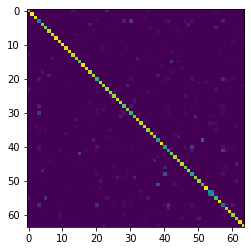

In [52]:
predicted_batch_pij_np = sinkhorn_knopp_model.predict(unsupervised_train_dataset, steps=1)[0]
plt.imshow(predicted_batch_pij_np)

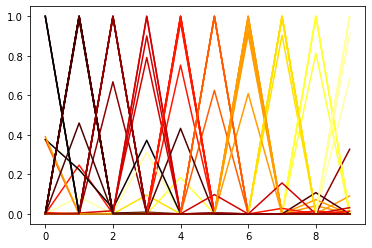

In [53]:
batch = next(iic_train_iterator)
logits_np = prediction_model.predict(x=batch[0]['image'], steps=1)[0]
for probs in tf.nn.softmax(logits_np).numpy():
    c = cm.hot(probs.argmax()/num_classes)
    plt.plot(probs, c=c)

0


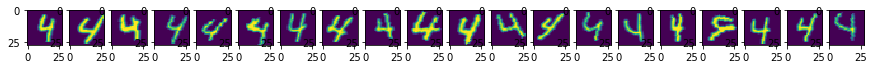

1


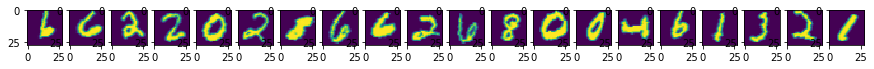

2


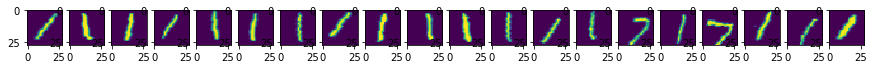

3


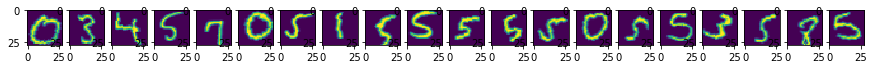

4


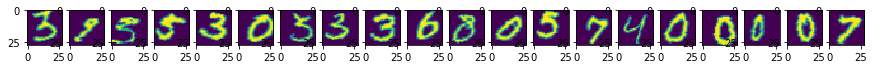

5


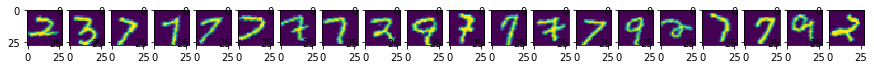

6


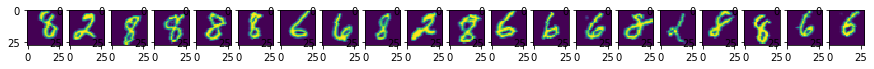

7


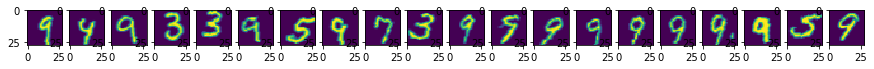

8


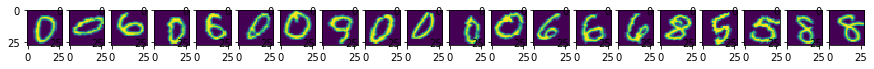

9


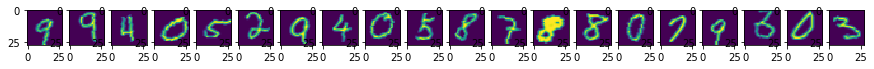

10


<Figure size 1080x288 with 0 Axes>

In [54]:
label = 0
label_count = 0
max_examples_per_label = 20
while True:
    if label_count == 0:
        print(label)
        plt.figure(figsize=(15, 4))
        
    if label == 10:
        break
    if label_count >= max_examples_per_label:
        plt.show()
        
        label_count = 0
        label += 1
        continue
    
    features, labels = next(iic_train_iterator)
    labels = labels['label'].numpy()
    predictions = prediction_model.predict(features['image'], steps=1)[0]
    for k, pred_label in enumerate(predictions.argmax(-1)):
        if pred_label == label and label_count < max_examples_per_label:            
            plt.subplot(1, max_examples_per_label, label_count + 1)
            plt.imshow(features['image'][k, :, :, 0])
            label_count += 1
plt.show()     